#Проект по сегментации изображений зуб улиток с микроскопа

In [ ]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=4d2a943ee74b6c33e9937cbf7f4160226215158a1b241463ddc58c050fb62a60
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=0be4e11c7876ae3dacb521e7467d71317096415349c76b33e96d91bb6eaf0b8b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [ ]:
#!rm -rf /content/data

In [ ]:
# Подключаем библиотеки

from matplotlib import pyplot as plt
import cv2
import numpy as np

import os
from typing import Tuple
from glob import glob

from torch.utils.data import Dataset
import albumentations as albu
from albumentations.pytorch import ToTensorV2

from torch.utils.data import DataLoader
import torch

import segmentation_models_pytorch as smp

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Mon Sep  4 18:54:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Загружаем данные (с моего диска)
!unzip /content/drive/MyDrive/data.zip -d /content/data

Archive:  /content/drive/MyDrive/data.zip
   creating: /content/data/mask/test/
  inflating: /content/data/mask/test/Lepthak_063a.tif  
  inflating: /content/data/mask/test/Lepthak_065.tif  
  inflating: /content/data/mask/test/Lepthak_065a.tif  
  inflating: /content/data/mask/test/Lepthak_066a.tif  
  inflating: /content/data/mask/test/Lepthak_067a.tif  
  inflating: /content/data/mask/test/Lepthak_077a.tif  
  inflating: /content/data/mask/test/Lepthak_081.tif  
   creating: /content/data/mask/train/
  inflating: /content/data/mask/train/Crasp_033a.tif  
  inflating: /content/data/mask/train/Crasp_035a.tif  
  inflating: /content/data/mask/train/Crasp_036a.tif  
  inflating: /content/data/mask/train/Crasp_037a.tif  
  inflating: /content/data/mask/train/Crasp_038a.tif  
  inflating: /content/data/mask/train/Crasp_051.tif  
  inflating: /content/data/mask/train/Crasp_052a.tif  
  inflating: /content/data/mask/train/LepiC_001.tif  
  inflating: /content/data/mask/train/LepiC_003.tif  

In [ ]:
# Визуализация изображения в 1 строке

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap='gray')
    plt.show()

In [ ]:
# Создаем класс датасета, который читает изображения и
# обрабатывает их поданным трансформером

class CustomImageDataset(Dataset):
    def __init__(
        self,
        path_to_img: str,
        path_to_mask: str,
        #resize_shape: list = (1024, 1024),
        transform=None,
    ) -> None:
        self.img_dir = path_to_img
        self.mask_dir = path_to_mask

        # Получаем пути к каждому файлу
        self.images = list(glob(os.path.join(self.img_dir, '*.tif'))) #[i for i in os.listdir(path_to_img) if i.endswith(".tiff")]
        #self.masks = [i for i in os.listdir(path_to_mask) if i.endswith(".tiff")]

        self.transform = transform
        #self.resize_shape = tuple(resize_shape)

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[np.array, np.array]:
        # Получаем путь к изображению и соответсвующей ей маске
        img_path = str(self.images[idx])
        mask_path = os.path.join(self.mask_dir, img_path.split("/")[-1])
        # Читаем изображения
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        # Сглаживаем края маски
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=3)

        # Выравнивание гистограммы
        image= cv2.equalizeHist(image)
        # Gaussian blur
        image = cv2.GaussianBlur(image, (31, 31), 0)

        if self.transform is not None:
            # применяем трансформацию к image и mask
            # Размываем изображение для лучшей сегментации
            #image = cv2.GaussianBlur(image, (23,23), 6)

            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            mask = torch.unsqueeze(mask, dim=0)
            # mask должна состоять из 0 и 1, исходные маски состоят из 0 и 255
            mask = mask / 255

            return image.float(), mask
        else:
            return image, mask

Маски у нас уже есть, были вырезаны из изначальных фотографий и обработаны

In [ ]:
# Определяем пути
img_train_dir = '/content/data/with_background/train'
mask_train_dir = '/content/data/mask/train'

img_test_dir = '/content/data/with_background/test'
mask_test_dir = '/content/data/mask/test'

In [ ]:
# трансформация состоящая из изменения разрешения, нормализации и приведения к
# тензору
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.3),
        #albu.RandomCrop(height=1024, width=1024, always_apply=True),
        albu.OneOf(
            [
                albu.CLAHE(p=0.5),
                albu.RandomGamma(p=0.5),
            ],
            p=0.5,
        ),
        albu.Sharpen(p=0.2),
        albu.RandomBrightnessContrast(p=0.2),
        albu.Resize(512, 512),
        albu.Normalize(mean=(0.449,), std=(0.226,)),
        ToTensorV2(),
    ]
    return albu.Compose(train_transform)


In [ ]:
def get_test_augmentation():
    test_transform = [
        albu.Resize(512, 512),
        albu.Normalize(mean=(0.449,), std=(0.226,)),
        ToTensorV2(),
    ]
    return albu.Compose(test_transform)

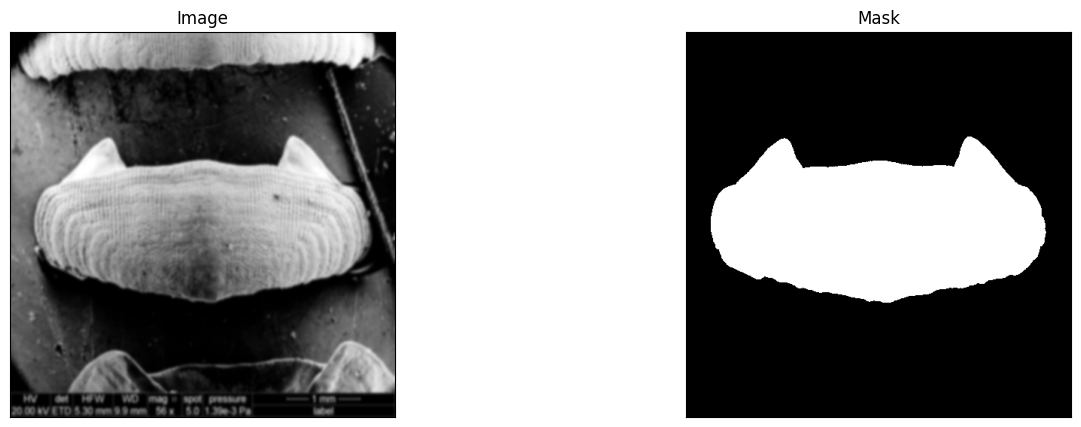

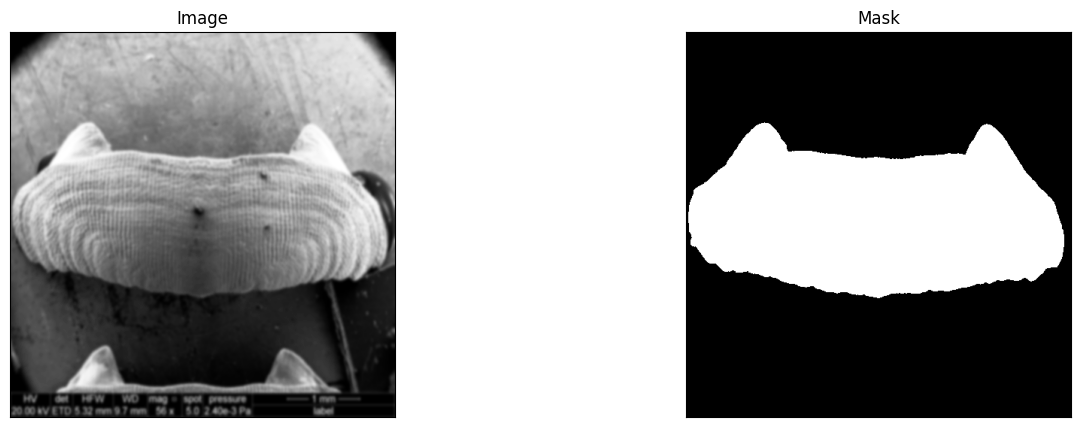

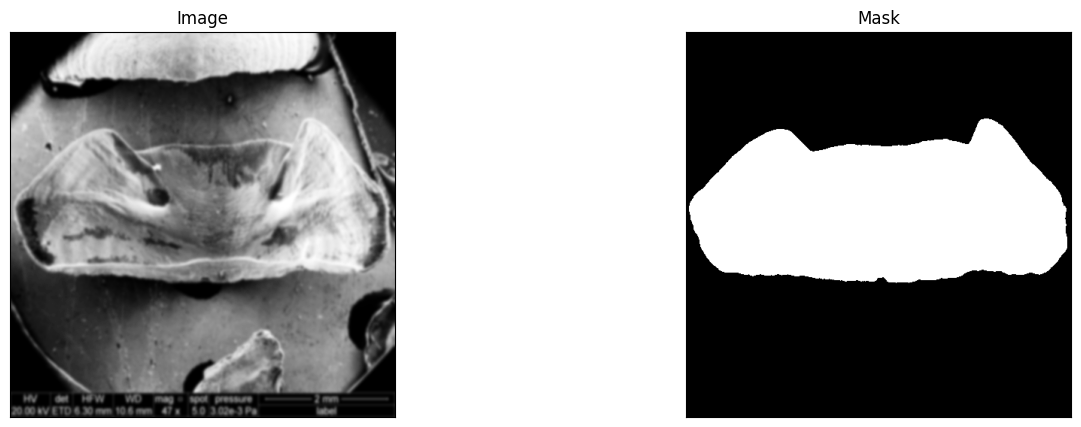

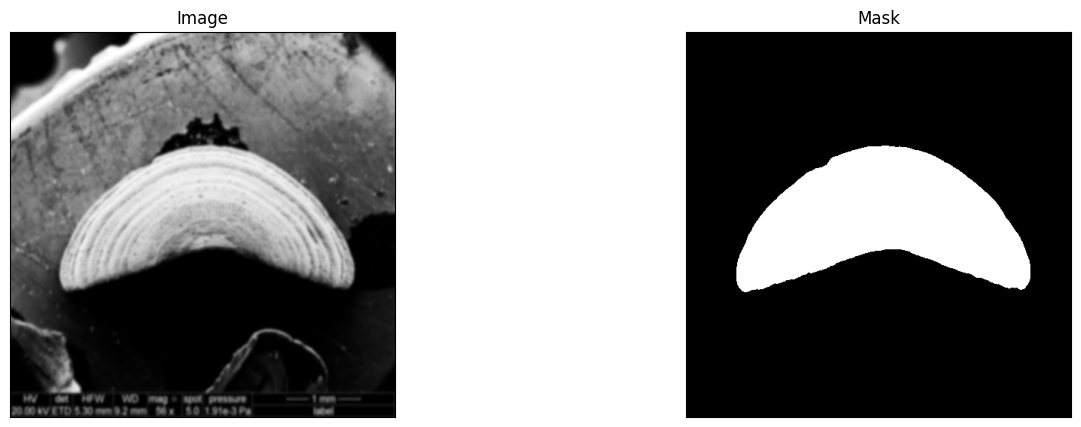

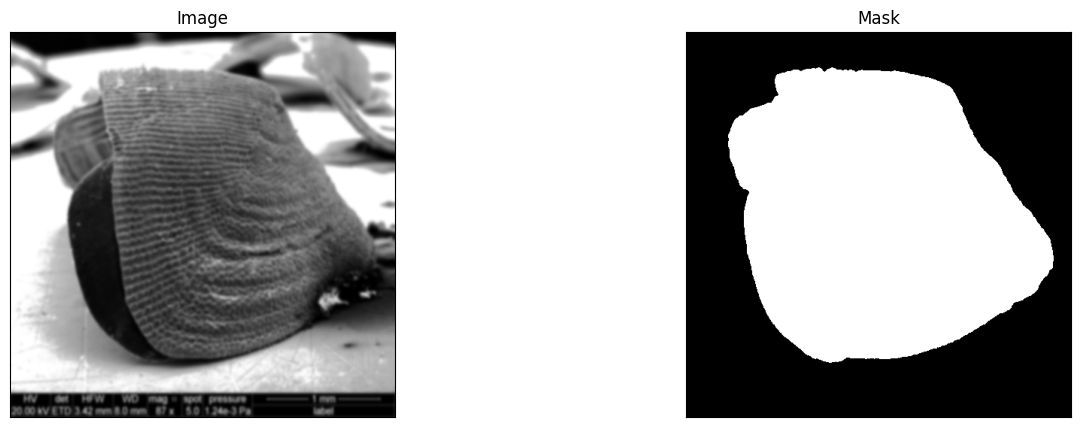

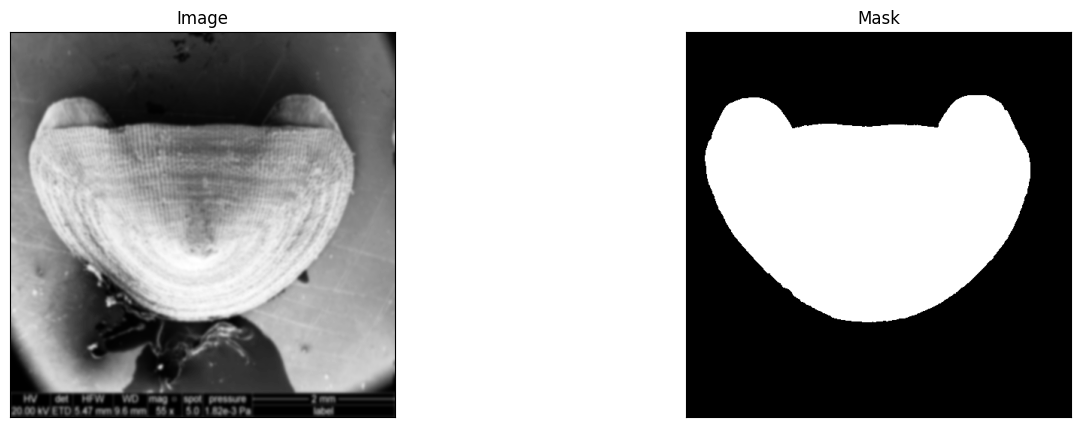

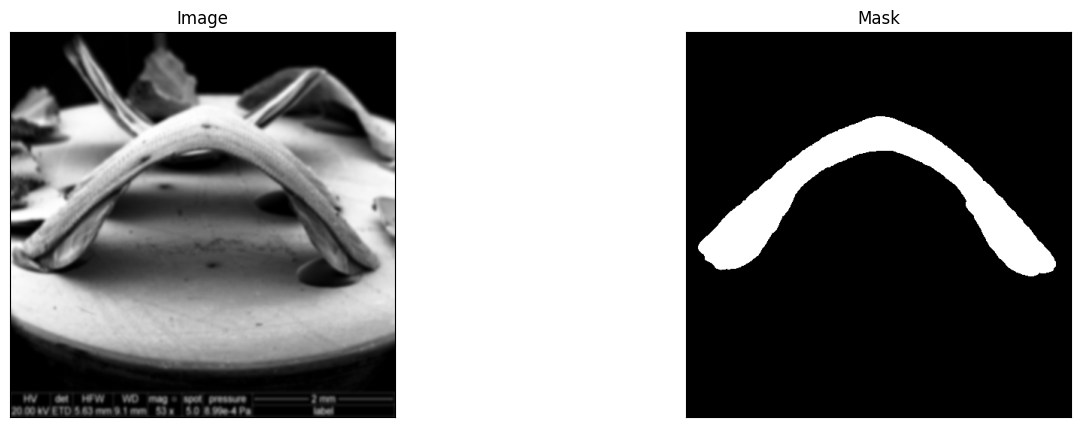

In [ ]:
# Проверяем работу написанных функций
test_dataset = CustomImageDataset(img_test_dir,
                             mask_test_dir,
                             transform=get_test_augmentation()
                             )


for image, mask in test_dataset:
    visualize(
        image=image[0],
        mask=mask[0],
    )

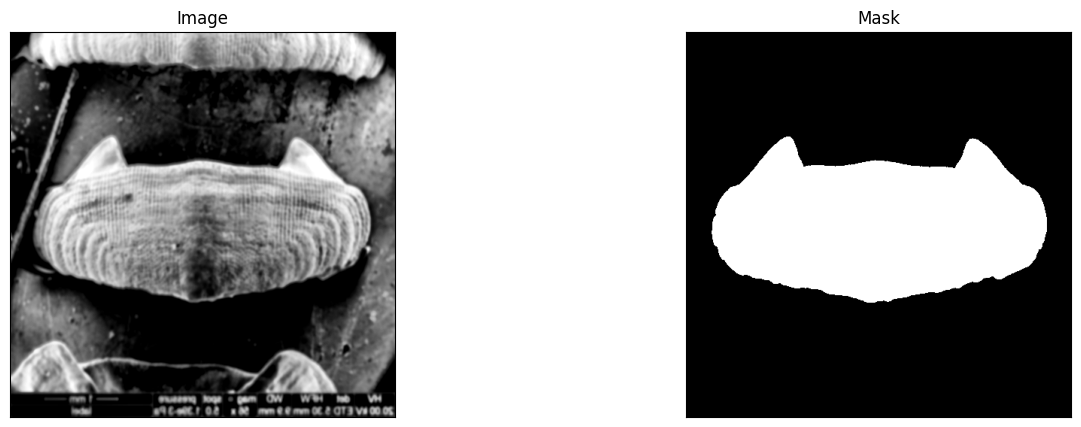

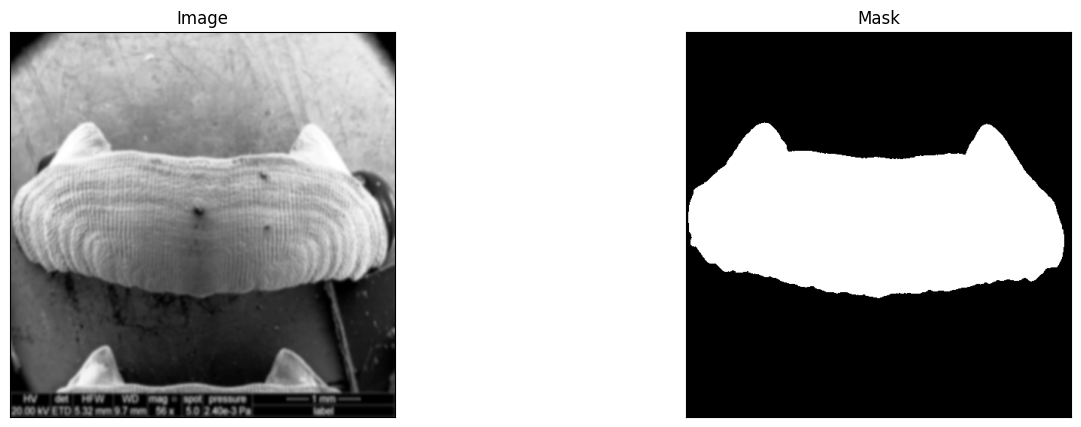

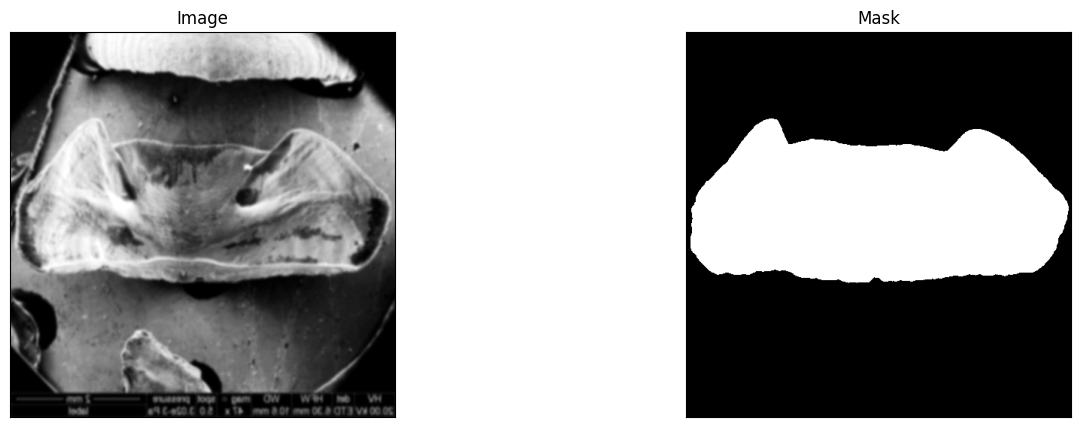

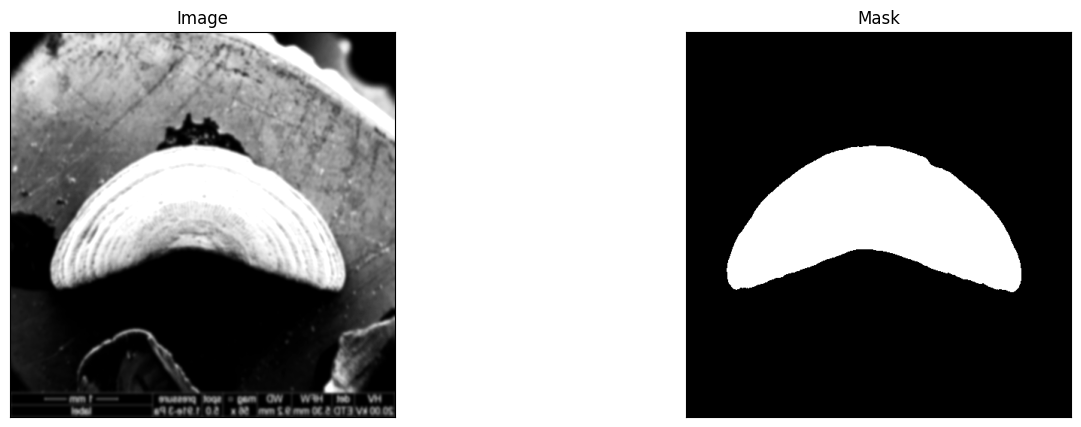

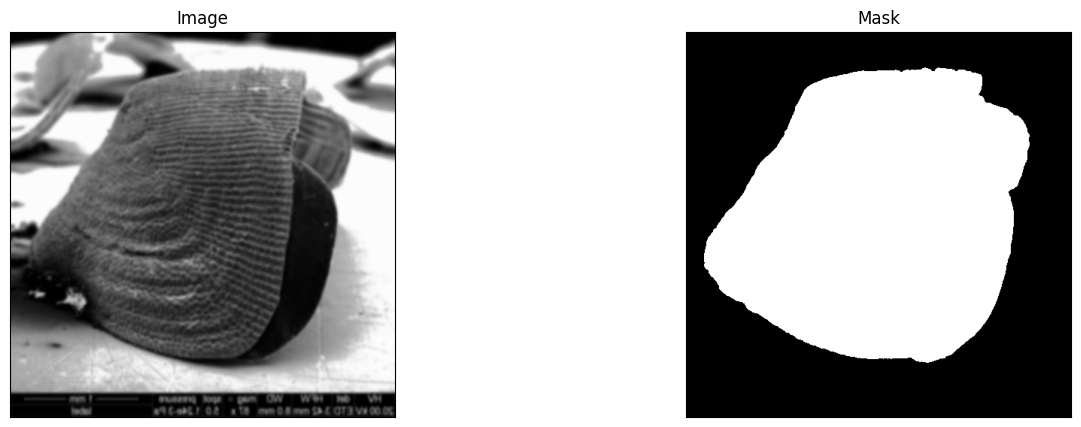

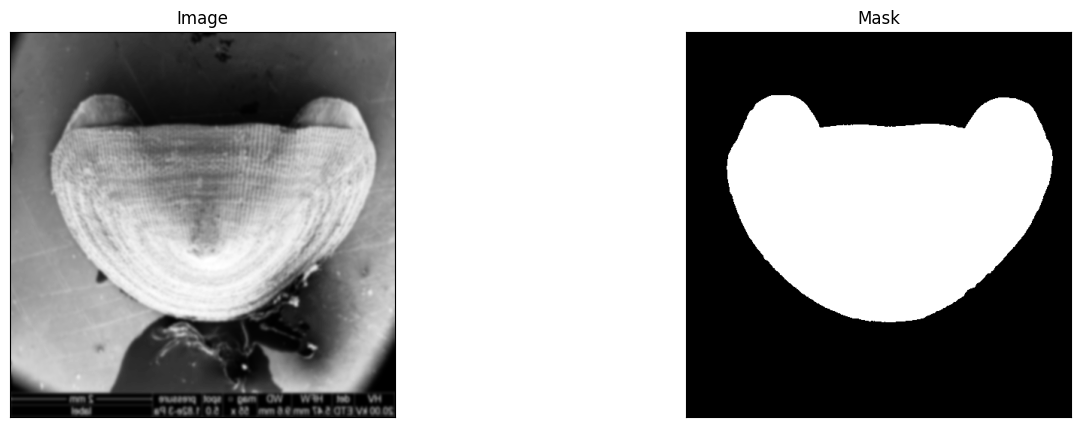

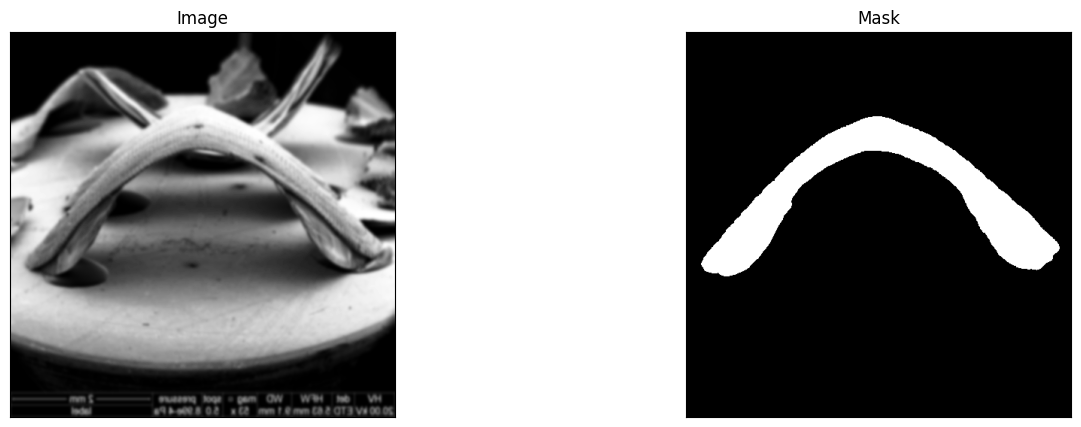

In [ ]:
# Проверяем работу написанных функций
test_dataset = CustomImageDataset(img_test_dir,
                             mask_test_dir,
                             transform=get_training_augmentation()
                             )

for image, mask in test_dataset:
    visualize(
        image=image[0],
        mask=mask[0],
    )
#cv2.morphologyEx(mask.numpy(), cv2.MORPH_OPEN,cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))

In [ ]:
image.shape, mask.shape

(torch.Size([1, 512, 512]), torch.Size([1, 512, 512]))

In [ ]:
train_dataset = CustomImageDataset(img_train_dir,
                             mask_train_dir,
                             transform=get_training_augmentation()
                             )

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [ ]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([6, 1, 512, 512]), torch.Size([6, 1, 512, 512]))

In [ ]:
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smputils

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
from torch._C import NoneType
import segmentation_models_pytorch as smp
import ssl

# Параметры модели
ENCODER = 'inceptionv4'
ENCODER_WEIGHTS = 'imagenet+background'
CLASSES = ['teeth']
#ACTIVATION = None
ACTIVATION = 'sigmoid'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Создаем модель
model = smp.UnetPlusPlus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
    in_channels=1,
)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionv4-8e4777a0.pth" to /root/.cache/torch/hub/checkpoints/inceptionv4-8e4777a0.pth
100%|██████████| 163M/163M [08:00<00:00, 356kB/s]


In [ ]:
# Определяем лосс, метрику и оптимизатор
#loss = smp.losses.TverskyLoss('binary', classes=None, log_loss=False,
#                              from_logits=False, smooth=0.0, ignore_index=None,
#                              alpha=1.,
#                              beta=0.2,
#                              eps=1e-07)
loss = smp.utils.losses.DiceLoss()
#loss.__name__='TverskyLoss'
#loss = torch.nn.BCEWithLogitsLoss()
#loss.__name__='BCElogits'
#loss.__name__ = 'cross'
metrics = [
   smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=1e-2),
])

In [ ]:
# Загружаем тестовые данные
test_dataset = CustomImageDataset(img_test_dir,
                             mask_test_dir,
                             transform=get_test_augmentation()
                             )

test_loader = DataLoader(test_dataset)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

In [ ]:
# Тренируем модель
max_score = 0
num_epochs = 40

train_losses = []
test_losses = []
for i in range(0, num_epochs):
    train_logs = train_epoch.run(train_loader)
    test_logs = test_epoch.run(test_loader)
    train_losses.append(train_logs['dice_loss'])
    test_losses.append(test_logs['dice_loss'])
    if max_score < test_logs['iou_score']:
        max_score = test_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
    print(i)
    # Оптимизация learning rate-а
    if i == 15:
        optimizer.param_groups[0]['lr'] = 1e-3
        print('Decrease decoder learning rate to 1e-3!')

    if i == 30:
        optimizer.param_groups[0]['lr'] = 1e-4
        print('Decrease decoder learning rate to 1e-4!')


valid: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s, dice_loss - 0.1339, iou_score - 0.7786]
Model saved!
0
train:  55%|█████▍    | 6/11 [00:17<00:14,  2.97s/it, dice_loss - 0.09925, iou_score - 0.8214]


KeyboardInterrupt: ignored

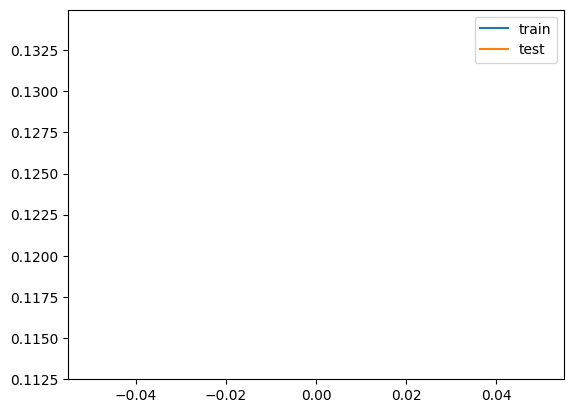

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.show()

In [ ]:
# Загружаем модель
best_model = torch.load('./best_model.pth', map_location=DEVICE)

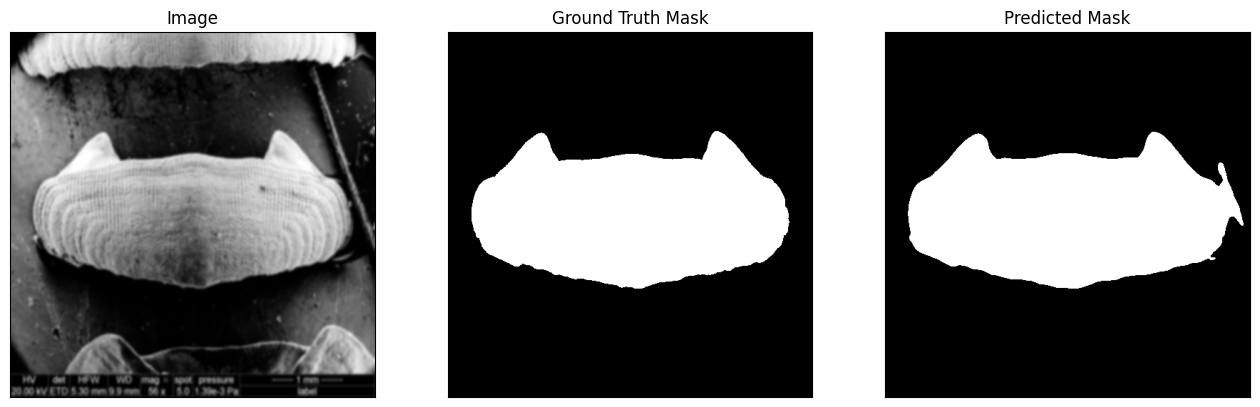

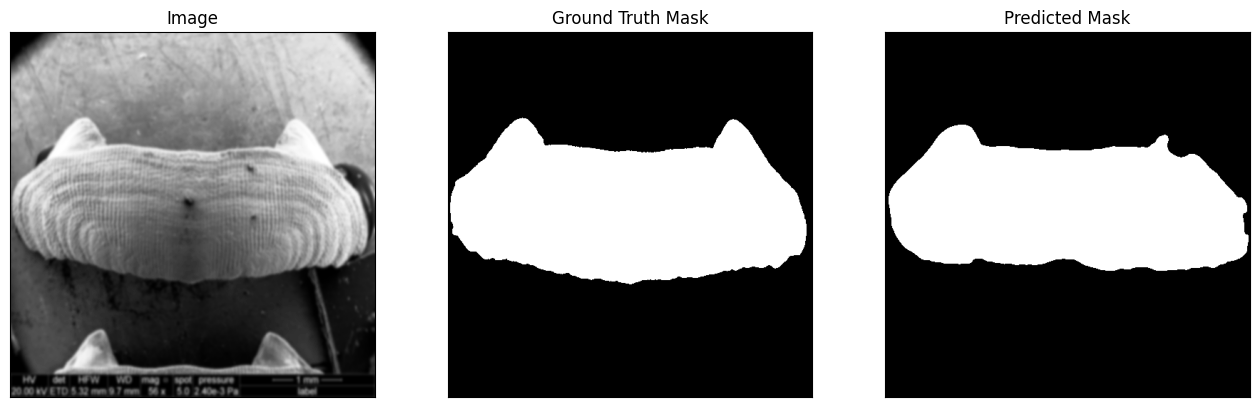

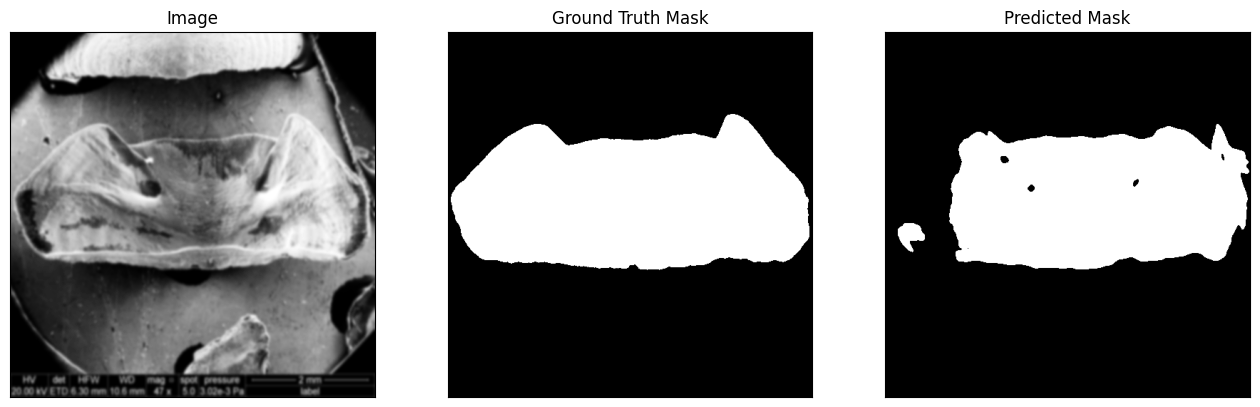

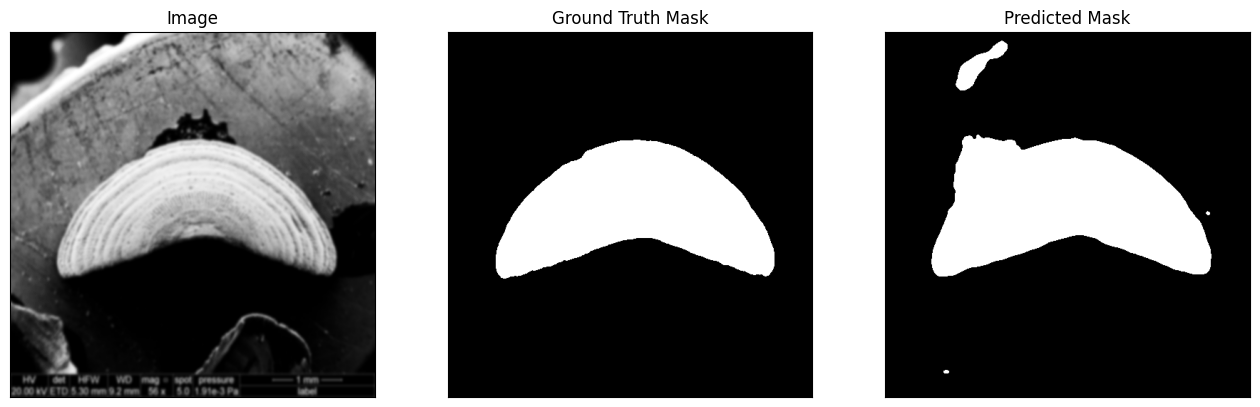

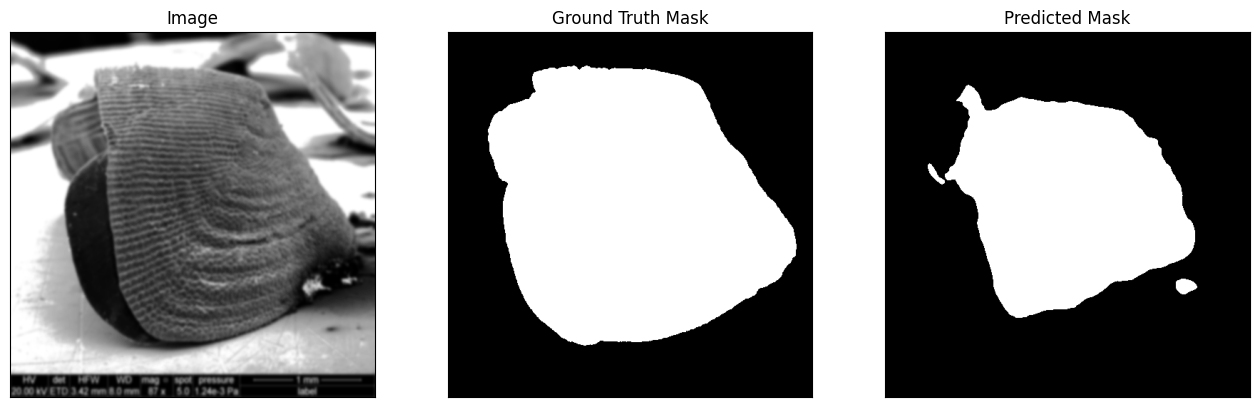

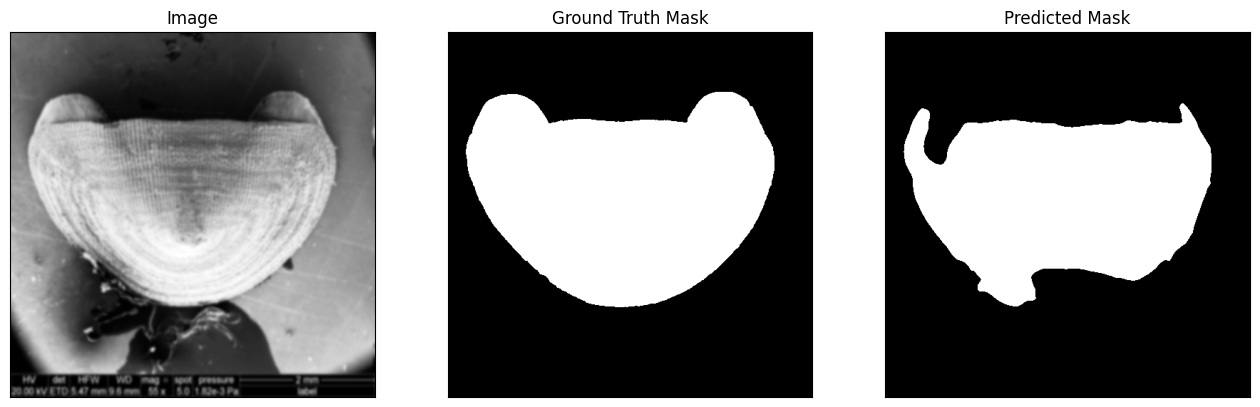

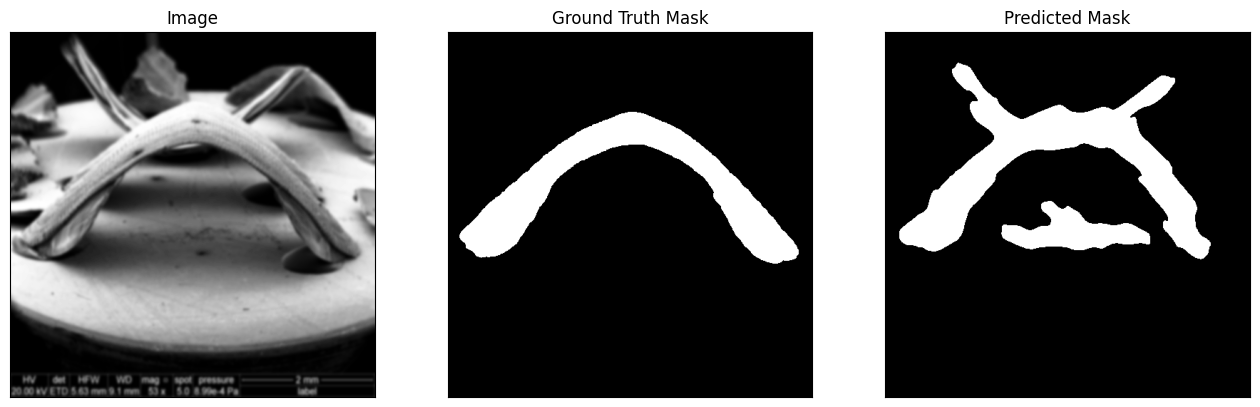

In [ ]:
test_images = []
pr_masks = []
# Применяем обученную модель к тестовым изображениям и выводим
for i in range(len(test_dataset)):
    #image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]

    gt_mask = gt_mask.squeeze()
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor.detach())
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    test_images.append(image)
    pr_masks.append(pr_mask)

    visualize(
        image=image[0],
        ground_truth_mask=gt_mask,
        predicted_mask=pr_mask
    )


In [ ]:
# Постпроцессинг, находим самый большой контур, избавляемся от шумов

def detect_largest_poly(mask: np.array) -> np.array:
    # преобразуем изображение в черно-белое
    #gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # находим контуры
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    # инициализируем переменную для хранения площади наибольшего полигонаF
    largest_area = 0
    largest_contour = None

    # перебираем все контуры
    for contour in contours:
        # вычисляем площадь текущего полигона
        area = cv2.contourArea(contour)
        # если площадь текущего полигона больше площади наибольшего полигона, то сохраняем его площадь
        if area > largest_area:
            largest_area = area
            largest_contour = contour

    image_copy = np.zeros(mask.shape)
    # копируем текущий полигон в изображение-копию
    cv2.drawContours(image_copy, [largest_contour], -1, 255, cv2.FILLED)
    return image_copy

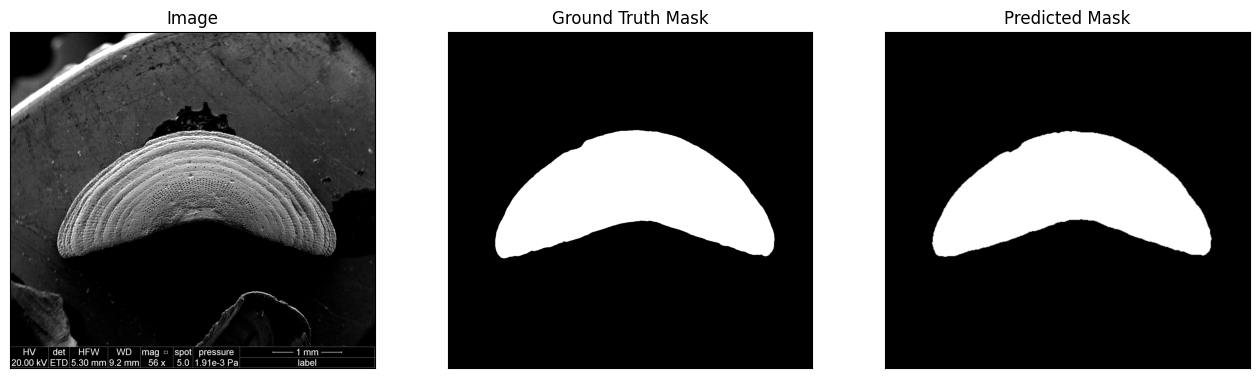

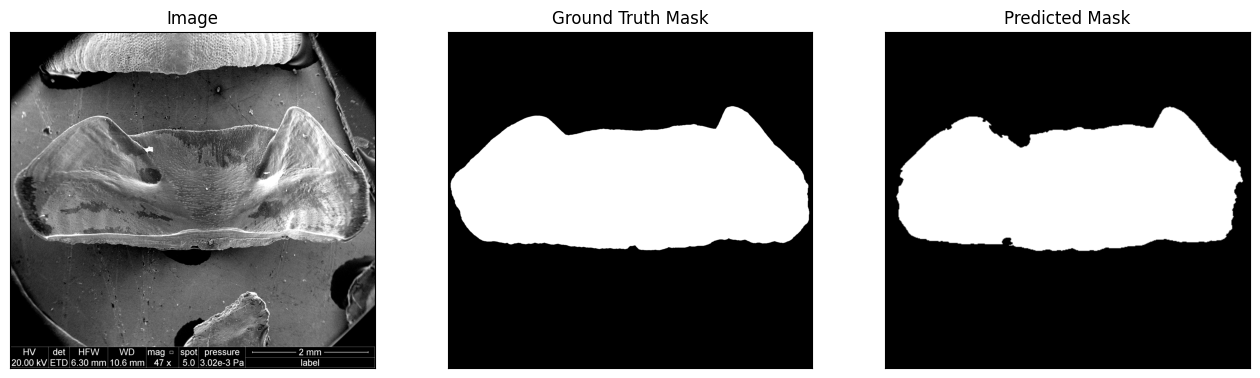

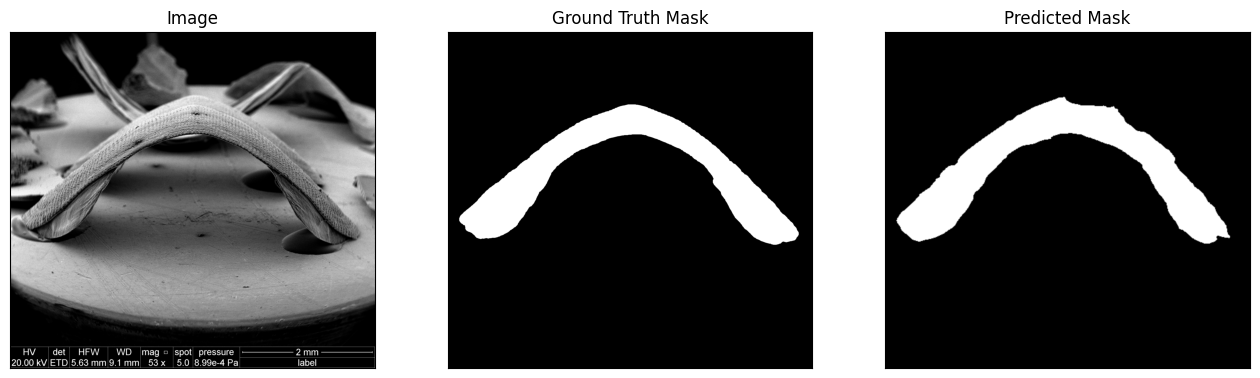

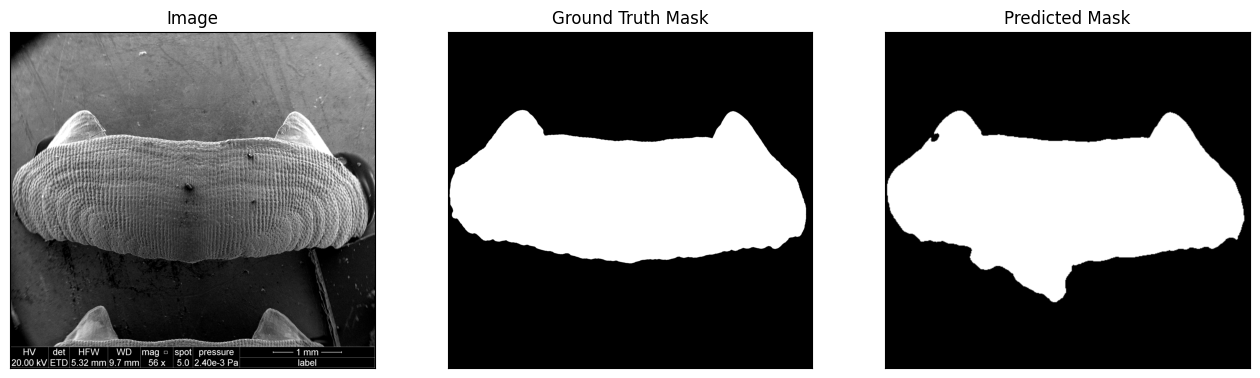

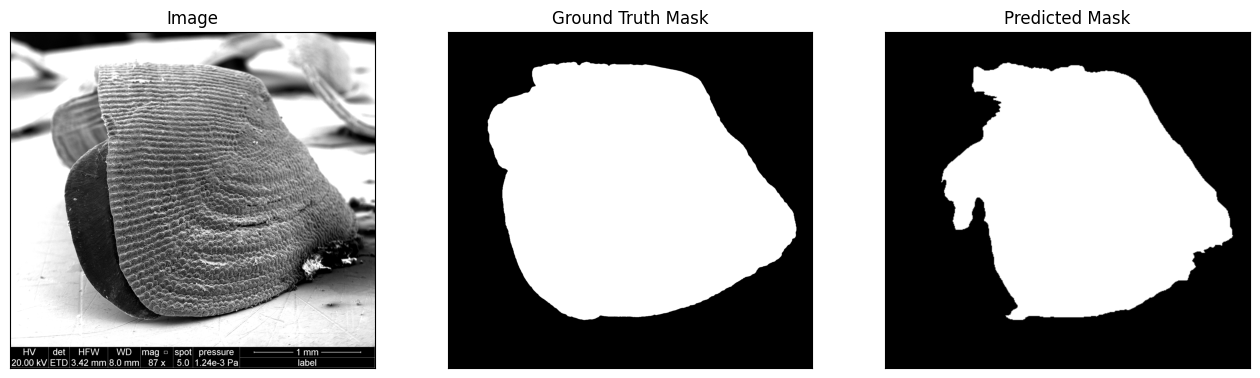

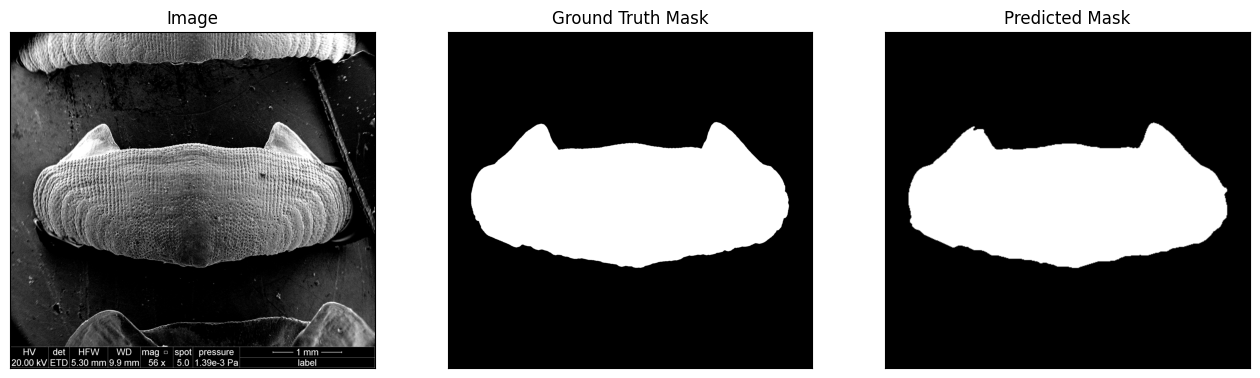

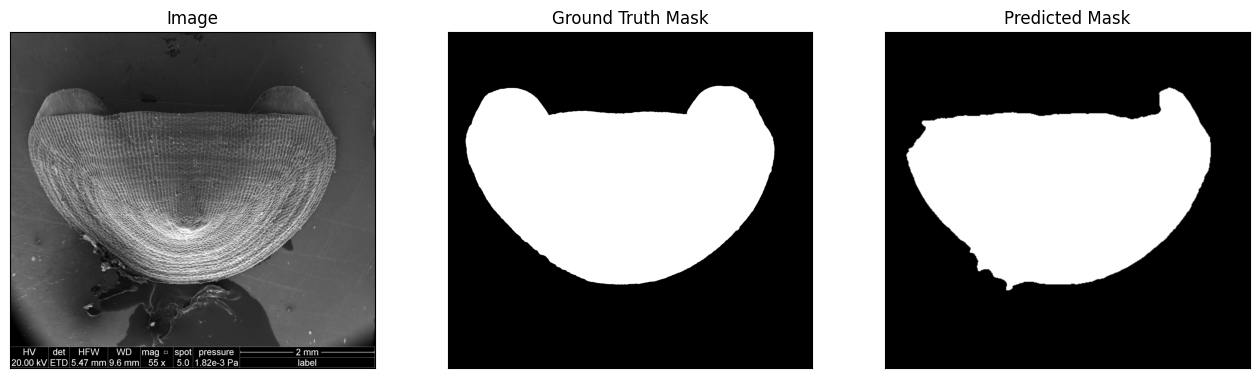

In [ ]:
# Визуализация конечного результата и возвращение к исходному размеру

orig_test_dataset = CustomImageDataset(img_test_dir,
                             mask_test_dir,
                             )
for i, val in enumerate(orig_test_dataset):

    image, gt_mask = val
    pr_mask = detect_largest_poly(pr_masks[i].astype(np.uint8))
    pr_mask = albu.Resize(1887, 2048)(image=pr_mask)['image']

    visualize(
        image=image,
        ground_truth_mask=gt_mask,
        predicted_mask=pr_mask
    )

Со сложными фотографиями есть проблемы, но общее расположение сеть находит, для простых фотографий результат идеальный
Сложности с некоторыми фотографиями связан с маленьким датасетом, возможно улучшение результата путем увеличения количества тренировочных данных
